## EXOD Detector MOS

Import

In [43]:
import sys
import os
import time
import shutil
from functools import partial
from datetime import datetime, date

# Third-party imports

from math import *
from multiprocessing import Pool
from astropy.io import fits
from astropy.table import Table, Column
from astropy import wcs
from astropy.coordinates import SkyCoord
from astropy import units as u
import numpy as np
import argparse
import matplotlib
matplotlib.use("Pdf")
from matplotlib import colors, image, transforms, gridspec
from matplotlib.patches import Circle
import matplotlib.pyplot as plt
from pylab import figure, cm

# Internal imports

from fits_extractor import *
from variability_utils import *
import file_names as FileNames
from file_utils import *
from renderer import *
from exodus_utils import *

Arguments

In [2]:
path = '/home/monrillo/data/0674210201/'
evts = path + 'PN_clean.fits'
img  = path + 'PN_image.fits'
gti  = path + 'PN_gti.fits'
out  = path + '8_300_5_1.0_PN/'
obs  = '0674210201'
bs   = 5
dl   = 8
tw   = 300
gtr  = 1.0
mta  = 8
inst = 'PN'
ol   = path + 'log.txt'
ccdnb = 12

In [24]:
path = '/home/monrillo/data/0674210201/'
evts = path + 'M1_clean.fits'
img  = path + 'M1_image.fits'
gti  = path + 'M1_gti.fits'
out  = path + '8_300_5_1.0_M1/'
obs  = '0674210201'
bs   = 5
dl   = 8
tw   = 300
gtr  = 1.0
mta  = 8
inst = 'M1'
ol   = path + 'log.txt'
ccdnb = 7

In [50]:
path = '/home/monrillo/data/0674210201/'
evts = path + 'M2_clean.fits'
img  = path + 'M2_image.fits'
gti  = path + 'M2_gti.fits'
out  = path + '8_300_5_1.0_M2/'
obs  = '0674210201'
bs   = 5
dl   = 8
tw   = 300
gtr  = 1.0
mta  = 8
inst = 'M2'
ol   = path + 'log.txt'
ccdnb = 7

Preliminaries

In [51]:
# Opening the output fileslog_f, var_f, reg_f = open_files(out)
log_f, var_f, reg_f = open_files(out)
sys.stdout = Tee(sys.stdout, log_f)

# Recovering the EVENTS list
data, header = extraction_photons(evts)

# Recovering the GTI list
gti_list = extraction_deleted_periods(gti)

# Computation of t0 and tf
t0_observation = min([evt['TIME'] for ccd in data for evt in ccd])
tf_observation = max([evt['TIME'] for ccd in data for evt in ccd])

In [52]:
submode = header['SUBMODE']

In [53]:
submode

'PrimeFullWindow'

#### Computing variability

In [54]:
v_matrix = []
var_calc_partial = partial(variability_computation, gti_list, tw, gtr, t0_observation, tf_observation, inst)

with Pool(mta) as p:
    v_matrix = p.map(var_calc_partial, data)

In [55]:
if inst == 'PN' :
    data_v = PN_config(v_matrix)
elif inst == 'M1' :
    data_v = M1_config(v_matrix)
elif inst == 'M2' :
    data_v = M2_config(v_matrix)

data_v = np.array(data_v)

In [8]:
#PN

if submode == 'PrimeLargeWindow' :
    data_vm = data_v[:,100:300]
if submode == 'PrimeSmallWindow' :
    data_vm = data_v[128:192,200:264]
else :
    data_vm = data_v

In [335]:
date_time = header['DATE-OBS']

In [336]:
date_time

'2007-12-29T13:19:11'

In [319]:
date_time = date_time[:10]+' '+date_time[11:]

In [320]:
date_time_obj = datetime.strptime(header['DATE-OBS'], '%Y-%m-%dT%H:%M:%S')

In [321]:
date_time_obj.date()

datetime.date(2014, 8, 9)

In [308]:
date_crash1 = date(2007, 2, 21)

In [322]:
date_time_obj.date() >= date_crash1

True

In [56]:
#MOS

data_vm = data_v
#data_vm = np.concatenate((data_v[:,1650:],data_v[:,:1650]),axis=1)
#data_vm = data_v[299:1499,:]

In [57]:
np.shape(data_vm)

(1800, 1800)

#### Geometrical transformations

In [58]:
# Header information
angle = header['PA_PNT']

xproj = [float(header['TDMIN6']), float(header['TDMAX6'])] # projected x limits
yproj = [float(header['TDMIN7']), float(header['TDMAX7'])] # projected y limits
xlims = [float(header['TLMIN6']), float(header['TLMAX6'])] # legal x limits
ylims = [float(header['TLMIN7']), float(header['TLMAX7'])] # legal y limits

# scaling factor
sx = 648 / (xlims[1] - xlims[0])
sy = 648 / (ylims[1] - ylims[0])

In [11]:
# PN

# pads (padding)
padX = (int((xproj[0] - xlims[0])*sx), int((xlims[1] - xproj[1])*sx))
padY = (int((yproj[0] - ylims[0])*sy), int((ylims[1] - yproj[1])*sy))
# shape (resizing)
pixX = 648 - (padX[0] + padX[1])
pixY = 648 - (padY[0] +padY[1])

# Transformations
## Rotation
dataR = np.flipud(nd.rotate(data_vm, angle, reshape = True))
## Resizing
dataT = skimage.transform.resize(dataR, (pixY, pixX), mode='constant', cval=0.0) # xy reversed
## Padding
dataP = np.pad(dataT, (padY, padX), 'constant', constant_values=0) # xy reversed

In [59]:
# MOS

# pads (padding)
interX = (int((xproj[0] - xlims[0])*sx), int((xlims[1] - xproj[1])*sx))
interY = (int((yproj[0] - ylims[0])*sy), int((ylims[1] - yproj[1])*sy))

numX = int((148-(interX[0] + interX[1]))/2)
numY = int((148-(interY[0] + interY[1]))/2)
    
padX = (interX[0]+numX, 148-(interX[0]+numX))
padY = (interY[0]+numY, 148-(interY[0]+numY))

# Transformations
## Rotation
dataR = np.flipud(nd.rotate(data_vm, angle, reshape = False))
## Resizing
dataT = skimage.transform.resize(dataR, (500, 500), mode='constant', cval=0.0)
## Padding
dataP = np.pad(dataT, (padY, padX), 'constant', constant_values=0) # xy reversed

In [251]:
# MOS TEST !!!

# pads (padding)
interX = (int((xproj[0] - xlims[0])*sx), int((xlims[1] - xproj[1])*sx))
interY = (int((yproj[0] - ylims[0])*sy), int((ylims[1] - yproj[1])*sy))

numX = int((148-(interX[0] + interX[1]))/2)
numY = int((148-(interY[0] + interY[1]))/2)
    
padX = (interX[0]+numX, 148-(interX[0]+numX))
padY = (interY[0]+numY, 148-(interY[0]+numY))

# Transformations
dataTest = skimage.transform.resize(data_vm, (1800, 1800), mode='constant', cval=0.0)
## Rotation
dataR = np.flipud(nd.rotate(dataTest, angle, reshape = False))
## Resizing
dataT = skimage.transform.resize(dataR, (500, 500), mode='constant', cval=0.0)
## Padding
dataP = np.pad(dataT, (padY, padX), 'constant', constant_values=0) # xy reversed

In [347]:
hdulist    = fits.open(img)
header_img = hdulist[0].header
hdulist.close()

# Creating fits file
hdul_f   = fits.HDUList()
hdul_var = fits.ImageHDU(data=dataP, header=header_img)
#hdul_src = fits.BinTableHDU(data=source_table)
hdul_f.append(hdul_var)
#hdul_f.append(hdul_src)

# Writing to file
file  = path + inst + '_variability_test.fits'

hdul_f.writeto(file, overwrite=True)

#### Variable areas

In [60]:
v_matrix = np.array(v_matrix)
median = np.median(v_matrix)

In [61]:
if median < 0.75 :
    median = 0.75

In [62]:
variable_areas = []
variable_areas_detection_partial = partial(variable_areas_detection, median, bs, dl, inst)

with Pool(mta) as p:
    variable_areas = p.map(variable_areas_detection_partial, v_matrix)

#### Searching for sources

In [63]:
sources = []
cpt_source = 0

# Computing source position
for ccd in range(ccdnb) :
    for source in variable_areas[ccd] :
        center_x = round(sum([p[0] for p in source]) / len(source), 2)
        center_y = round(sum([p[1] for p in source]) / len(source), 2)

        r = round(sqrt( (max([abs(p[0] - center_x) for p in source]))**2 + (max([abs(p[1] - center_y) for p in source]))**2 ), 2)

        # Avoiding bad pixels
        if [inst, ccd, int(center_x)] not in [['PN',4,11], ['PN',4,12], ['PN',4,13], ['PN',5,12], ['PN',10,28]] :
            cpt_source += 1
            sources.append([cpt_source, inst, ccd+1, center_x, center_y, r])

In [64]:
source_table = Table(names=('ID', 'INST', 'CCDNR', 'RAWX', 'RAWY', 'RAWR', 'X', 'Y', 'SKYR', 'RA', 'DEC', 'R')\
                     , dtype=('i2', 'U25', 'i2', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8'))
for i in range(len(sources)) :
    
    # Getting Source class
    src = Source(sources[i])
    src.sky_coord(path, img, log_f)
    
    # Adding source to table
    source_table.add_row([src.id_src, src.inst, src.ccd, src.rawx, src.rawy, src.rawr, src.x, src.y, src.skyr, src.ra, src.dec, src.r])

#### Writing FITS

In [65]:
hdulist    = fits.open(img)
header_img = hdulist[0].header
hdulist.close()

# Creating fits file
hdul_f   = fits.HDUList()
hdul_var = fits.ImageHDU(data=dataP, header=header_img)
hdul_src = fits.BinTableHDU(data=source_table)
hdul_f.append(hdul_var)
hdul_f.append(hdul_src)

# Writing to file
file  = path + inst + '_variability_test.fits'

hdul_f.writeto(file, overwrite=True)

##### WCS Transformation

In [66]:
# Opening variability file
hdulist = fits.open(file)

data   = hdulist[0].data
src    = hdulist[1].data
header = hdulist[0].header

hdulist.close()

# Obtaining the WCS transformation parameters

header.rename_keyword('RADECSYS', 'RADESYS')

w = wcs.WCS(header)

w.wcs.crpix = [header['REFXCRPX'], header['REFYCRPX']]
w.wcs.cdelt = [header['REFXCDLT']/15, header['REFYCDLT']]
w.wcs.crval = [header['REFXCRVL']/15, header['REFYCRVL']]
w.wcs.ctype = [header['REFXCTYP'], header['REFYCTYP']]

# Image limit
dlim = [header['REFXLMIN'], header['REFXLMAX'], header['REFYLMIN'], header['REFYLMAX']]

#### Computing sources list

In [67]:
if inst == 'PN':
    src_PN = Table(src)
elif inst == 'M1':
    src_M1 = Table(src)
elif inst == 'M2':
    src_M2 = Table(src)

In [68]:
corr_table = Table(names=('ID_1', 'INST_1', 'RA_1', 'DEC_1', 'R_1','ID_2', 'INST_2', 'RA_2', 'DEC_2', 'R_2')\
                   , dtype=('i2', 'U25', 'f8', 'f8', 'f8','i2', 'U25', 'f8', 'f8', 'f8'))

In [69]:
check_correlation(src_PN, src_M1, corr_table)
check_correlation(src_M1, src_M2, corr_table)
check_correlation(src_PN, src_M2, corr_table)

ID_1,INST_1,RA_1,DEC_1,R_1,ID_2,INST_2,RA_2,DEC_2,R_2
int16,str25,float64,float64,float64,int16,str25,float64,float64,float64
1,M1,10.6178,41.1674,9.056000000000001,1,M2,10.6189,41.1678,9.056000000000001
2,M1,10.6177,41.2074,9.056000000000001,3,M2,10.6195,41.2077,9.056000000000001
3,M1,10.7928,41.2487,9.056000000000001,15,M2,10.7937,41.2499,9.056000000000001
4,M1,10.6329,41.221,9.056000000000001,4,M2,10.6346,41.2214,9.056000000000001
5,M1,10.7622,41.256,9.056000000000001,14,M2,10.7641,41.2591,9.056000000000001
6,M1,10.7639,41.2582,9.056000000000001,14,M2,10.7641,41.2591,9.056000000000001
10,M1,10.7288,41.2677,9.056000000000001,11,M2,10.7292,41.2686,9.056000000000001
12,M1,10.6971,41.2729,28.64,9,M2,10.6846,41.2765,12.512
12,M1,10.6971,41.2729,28.64,10,M2,10.6967,41.2709,9.056000000000001


In [70]:
corr_PN_M1 = corr_table[np.where((corr_table['INST_1']=='PN') & (corr_table['INST_2']=='M1'))]
corr_M1_M2 = corr_table[np.where((corr_table['INST_1']=='M1') & (corr_table['INST_2']=='M2'))]
corr_PN_M2 = corr_table[np.where((corr_table['INST_1']=='PN') & (corr_table['INST_2']=='M2'))]

In [75]:
src_triple = []
if len(corr_PN_M1) !=0 and len(corr_M1_M2) !=0 and len(corr_PN_M2) !=0:
    src_triple = check_triple(corr_PN_M1, corr_M1_M2, corr_PN_M2)

In [126]:
hdulist = fits.open(file0)

data   = hdulist[0].data
src    = hdulist[1].data
header = hdulist[0].header

hdulist.close()

In [148]:
src_PN=Table(src)

In [150]:
src_PN.sort(['R'])
src_PN.reverse()

In [151]:
src_PN

ID,INST,CCDNR,RAWX,RAWY,RAWR,X,Y,SKYR,RA,DEC,R
int16,str25,int16,float64,float64,float64,float64,float64,float64,float64,float64,float64
4,PN,4,34.65,192.77,6.38,27398.01,27751.44,408.32,76.9524,30.4041,20.416
9,PN,5,58.0,73.5,4.61,30377.89,17747.67,295.04,76.9045,30.2652,14.752
8,PN,5,34.5,141.5,3.54,32588.81,23260.79,226.56,76.8689,30.3417,11.328
3,PN,2,53.5,53.5,3.54,14504.85,16867.39,226.56,77.1597,30.2528,11.328
5,PN,4,35.5,122.0,3.2,27043.76,21918.95,204.8,76.9581,30.3231,10.24
13,PN,10,60.0,171.0,2.83,24601.02,31042.71,181.12,76.9974,30.4498,9.056
12,PN,10,29.0,51.0,2.83,22526.49,41062.74,181.12,77.0309,30.589,9.056
11,PN,7,16.0,34.0,2.83,26918.01,42254.12,181.12,76.9601,30.6055,9.056
10,PN,5,57.0,122.0,2.83,30655.09,21743.11,181.12,76.9,30.3206,9.056


In [131]:
essai = []
for i in range(len(src_PN)):
    for j in range(i+1,len(src_PN)):
        c1 = SkyCoord(src_PN['RA'][i], src_PN['DEC'][i], frame='fk5', unit='deg')
        c2 = SkyCoord(src_PN['RA'][j], src_PN['DEC'][j], frame='fk5', unit='deg')
        sep = c1.separation(c2)
        #if sep.arcsecond < (src_M2['R'][i]-(src_M2['R'][j]/2)):
        if sep.arcsecond < (src_PN['R'][i]):
            essai.append(j)

In [152]:
c1 = SkyCoord(src_PN['RA'][0], src_PN['DEC'][0], frame='fk5', unit='deg')
c2 = SkyCoord(src_PN['RA'][10], src_PN['DEC'][10], frame='fk5', unit='deg')
sep = c1.separation(c2)

In [153]:
sep.arcsecond

26.170528889298527

In [147]:
src_PN

ID,INST,CCDNR,RAWX,RAWY,RAWR,X,Y,SKYR,RA,DEC,R
int16,str25,int16,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,PN,4,34.65,192.77,6.38,27398.01,27751.44,408.32,76.9524,30.4041,20.416
2,PN,5,58.0,73.5,4.61,30377.89,17747.67,295.04,76.9045,30.2652,14.752
3,PN,5,34.5,141.5,3.54,32588.81,23260.79,226.56,76.8689,30.3417,11.328
4,PN,2,53.5,53.5,3.54,14504.85,16867.39,226.56,77.1597,30.2528,11.328
5,PN,4,35.5,122.0,3.2,27043.76,21918.95,204.8,76.9581,30.3231,10.24
6,PN,10,60.0,171.0,2.83,24601.02,31042.71,181.12,76.9974,30.4498,9.056
7,PN,10,29.0,51.0,2.83,22526.49,41062.74,181.12,77.0309,30.589,9.056
8,PN,7,16.0,34.0,2.83,26918.01,42254.12,181.12,76.9601,30.6055,9.056
9,PN,5,57.0,122.0,2.83,30655.09,21743.11,181.12,76.9,30.3206,9.056


#### Displaying

In [78]:
maximum_value = max([max(tmp) for tmp in data])

In [79]:
maximum_value

4.036805166413706

In [136]:
# Plotting the variability data
%matplotlib notebook
plt.subplot(111, projection=w)

im = plt.imshow(data, cmap=cm.inferno, norm=colors.LogNorm(vmin=0.1, vmax=maximum_value), extent=dlim)

ax = plt.gca()
ax.set_facecolor('k')
cbar = plt.colorbar(im)

# Plotting the sources
if len(src) != 0 :
    # Position of the sources
    for s in src:
        plt.plot(s['X'], s['Y'], 'wo', alpha = 1, fillstyle='none', ms=s['RAWR'],zorder=1)
        if header['INSTRUME']=='EPN':
            if s['ID'] in np.append(np.array(corr_PN_M1['ID_1']),np.array(corr_PN_M2['ID_1'])):
                plt.plot(s['X'], s['Y'], 'bo', alpha = 1, fillstyle='none', ms=s['RAWR'],zorder=2)
            for j in range(len(src_triple)):
                if s['ID']==src_triple[j][0]:
                    plt.plot(s['X'], s['Y'], 'go', alpha = 1, fillstyle='none', ms=s['RAWR'],zorder=3)
        elif header['INSTRUME']=='EMOS1':
            if s['ID'] in np.append(np.array(corr_PN_M1['ID_2']),np.array(corr_M1_M2['ID_1'])):
                plt.plot(s['X'], s['Y'], 'bo', alpha = 1, fillstyle='none', ms=s['RAWR'],zorder=2)
            for j in range(len(src_triple)):
                if s['ID']==src_triple[j][2]:
                    plt.plot(s['X'], s['Y'], 'go', alpha = 1, fillstyle='none', ms=s['RAWR'],zorder=3)
        elif header['INSTRUME']=='EMOS2':
            if s['ID'] in np.append(np.array(corr_M1_M2['ID_2']),np.array(corr_PN_M2['ID_2'])):
                plt.plot(s['X'], s['Y'], 'bo', alpha = 1, fillstyle='none', ms=s['RAWR'],zorder=2)
            for j in range(len(src_triple)):
                if s['ID']==src_triple[j][4]:
                    plt.plot(s['X'], s['Y'], 'go', alpha = 1, fillstyle='none', ms=s['RAWR'],zorder=3)
        

ra  = ax.coords[0]
dec = ax.coords[1]

ra.display_minor_ticks(True)
dec.display_minor_ticks(True)
ax.tick_params(axis='both', which='both', direction='in', color='w', width=1)

# Labels
plt.xlabel('RA', fontsize=10)
plt.ylabel('DEC', fontsize=10)
cbar.ax.set_ylabel('Variability', fontsize=10)

#plt.table(src)

# Title
plt.title('OBS {0}   Inst: {1}'.format(header['OBS_ID'], header['INSTRUME']), fontsize=14)
plt.text(0.5, 0.95, "TW {0} s    DL {1}   BS {2}".format(tw, dl, bs), color='white', fontsize=10, horizontalalignment='center', transform = ax.transAxes)

<IPython.core.display.Javascript object>

NameError: name 'corr_PN_M1' is not defined

#### Test

In [144]:
2 in np.append(np.array(corr_PN_M1['ID_1']),np.array(corr_PN_M2['ID_1']))

False

In [103]:
src

FITS_rec([( 1, 'M2', 1,  56.  ,  28.  , 2.83, 31049.85, 19935.6 , 181.12, 10.6189, 41.1678,  9.056),
          ( 2, 'M2', 1,  76.  , 363.  , 2.83, 32635.25, 27151.79, 181.12, 10.5895, 41.268 ,  9.056),
          ( 3, 'M2', 1,  93.  , 153.  , 2.83, 31015.74, 22805.35, 181.12, 10.6195, 41.2077,  9.056),
          ( 4, 'M2', 1, 141.  , 186.  , 2.83, 30196.87, 23792.25, 181.12, 10.6346, 41.2214,  9.056),
          ( 5, 'M2', 1, 239.5 , 305.  , 3.2 , 28824.03, 26903.72, 204.8 , 10.6599, 41.2646, 10.24 ),
          ( 6, 'M2', 1, 241.  , 317.  , 2.83, 28864.22, 27166.91, 181.12, 10.6592, 41.2683,  9.056),
          ( 7, 'M2', 1, 256.  , 312.  , 2.83, 28516.49, 27150.96, 181.12, 10.6656, 41.268 ,  9.056),
          ( 8, 'M2', 1, 258.  , 296.  , 2.83, 28378.17, 26824.02, 181.12, 10.6681, 41.2635,  9.056),
          ( 9, 'M2', 1, 308.5 , 326.  , 3.91, 27488.35, 27762.37, 250.24, 10.6846, 41.2765, 12.512),
          (10, 'M2', 1, 332.  , 300.  , 2.83, 26834.63, 27352.55, 181.12, 10.6967, 41.2709,

# Test Affichage

In [2]:
path = '/home/monrillo/data/0401870301/'
obs  = '0401870301'
bs   = 5
dl   = 8
tw   = 300
gtr  = 1.0

In [3]:
file0 = path + '{}_{}_{}_{}_PN/'.format(int(dl), int(tw), bs, gtr) + FileNames.VARIABILITY
file1 = path + '{}_{}_{}_{}_M1/'.format(int(dl), int(tw), bs, gtr) + FileNames.VARIABILITY
file2 = path + '{}_{}_{}_{}_M2/'.format(int(dl), int(tw), bs, gtr) + FileNames.VARIABILITY

In [4]:
# PN source list
hdulist = fits.open(file0)
src_PN = Table(hdulist[1].data)
hdulist.close()
# MOS 1 source list
hdulist = fits.open(file1)
src_M1 = Table(hdulist[1].data)
hdulist.close()
# MOS 2 source list
hdulist = fits.open(file2)
src_M2 = Table(hdulist[1].data)
hdulist.close()

# Checking correlation between lists

# Implementing correlation table
corr_table = Table(names=('ID_1', 'INST_1', 'RA_1', 'DEC_1', 'R_1','ID_2', 'INST_2', 'RA_2', 'DEC_2', 'R_2')\
                   , dtype=('i2', 'U25', 'f8', 'f8', 'f8','i2', 'U25', 'f8', 'f8', 'f8'))

# Checking correlation for the 3 EPIC
corr_table=check_correlation(src_PN, src_M1, corr_table)
corr_table=check_correlation(src_M1, src_M2, corr_table)
corr_table=check_correlation(src_PN, src_M2, corr_table)

# Sorting the table
corr_PN_M1 = corr_table[np.where((corr_table['INST_1']=='PN') & (corr_table['INST_2']=='M1'))]
corr_M1_M2 = corr_table[np.where((corr_table['INST_1']=='M1') & (corr_table['INST_2']=='M2'))]
corr_PN_M2 = corr_table[np.where((corr_table['INST_1']=='PN') & (corr_table['INST_2']=='M2'))]

# Checking for triple correlation
src_triple = []
if len(corr_PN_M1) !=0 and len(corr_M1_M2) !=0 and len(corr_PN_M2) !=0:
    src_triple = check_triple(corr_PN_M1, corr_M1_M2, corr_PN_M2)

In [76]:
c = SkyCoord(ra=src_ap['RA'][0]*u.degree, dec=src_ap['DEC'][0]*u.degree, frame='fk5')

In [21]:
int(src_ap['X'][0]),int(src_ap['Y'][0])

(27175, 27563)

In [22]:
src_ap['R'][0]

66.976

In [78]:
c.to_string('hmsdms')

'05h07m49.44s +30d24m05.4s'

In [79]:
c2 = SkyCoord(ra=5.1317*u.degree, dec=src_ap['DEC'][0]*u.degree, frame='fk5')

In [84]:
c2.to_string('hmsdms').split()

['00h20m31.608s', '+30d24m05.4s']

<IPython.core.display.Javascript object>


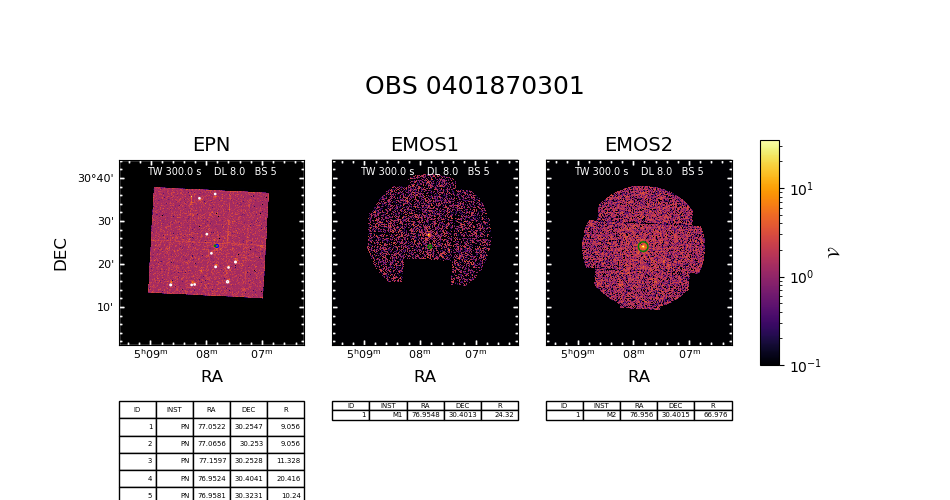

Text(0.5, 0.85, 'OBS 0401870301')

In [80]:
%matplotlib notebook
var_files = [file0, file1, file2]

# Starting loop on the different parameters
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9.5,5))
gs = gridspec.GridSpec(1, 3, wspace=0.15, hspace=0.6)

for i in range(len(var_files)) :

    hdulist = fits.open(var_files[i])

    data   = hdulist[0].data
    src    = hdulist[1].data
    header = hdulist[0].header

    hdulist.close()

    # Obtaining the WCS transformation parameters
    header.rename_keyword('RADECSYS', 'RADESYS')
    w = wcs.WCS(header)

    w.wcs.crpix = [header['REFXCRPX'], header['REFYCRPX']]
    w.wcs.cdelt = [header['REFXCDLT'], header['REFYCDLT']]
    w.wcs.crval = [header['REFXCRVL'], header['REFYCRVL']]
    w.wcs.ctype = [header['REFXCTYP'], header['REFYCTYP']]

    # Image limit
    dlim = [header['REFXLMIN'], header['REFXLMAX'], header['REFYLMIN'], header['REFYLMAX']]
        
    # Limite maximale de l'échelle des couleurs pour la normalisation par logarithme
    maximum_value = max([max(tmp) for tmp in data])

    # Plotting the variability data
    plt.subplot(gs[i], projection=w)
    ax = plt.gca()
    
    if i == 0:
        im = plt.imshow(data, cmap=cm.inferno, norm=colors.LogNorm(vmin=0.1, vmax=maximum_value), extent=dlim)
    else:
        im = plt.imshow(data*4, cmap=cm.inferno, norm=colors.LogNorm(vmin=0.1, vmax=maximum_value), extent=dlim)

    # Plotting the sources
    if len(src) != 0 :
        src_ap = correl_flag(src, corr_table, src_triple)
        for s in src_ap:
            if s['correl']=='':
                circ = Circle((s['X'],s['Y']), s['SKYR'],color="none", ec='white')
                ax.add_patch(circ)
                                    
            elif s['correl']!='' and s['correl']!='Triple':
                circ = Circle((s['X'],s['Y']), s['SKYR'],color="none", ec='blue')
                ax.add_patch(circ)
                                    
            elif s['correl']=='Triple':
                circ = Circle((s['X'],s['Y']), s['SKYR'],color="none", ec='green')
                ax.add_patch(circ)
        
                    
    plt.text(0.5, 0.92, "TW {0} s    DL {1}   BS {2}".format(header['TW'], header['DL'], header['BS']),\
                color='white', fontsize=7, horizontalalignment='center', transform = ax.transAxes)
    
    plt.title('{0}'.format(header['INSTRUME']), fontsize=14)
    
    src1=Table(src)
    dat=src1['ID', 'INST', 'RA', 'DEC', 'R']
    l=0.1*len(dat)
    src_table = plt.table(cellText=dat, colLabels=dat.colnames, colLoc='center',\
                          loc='top', bbox=[0.0,-(0.3+l),1,l])
    src_table.set_fontsize(20)
    #src_table.scale(1,3)

    ra  = ax.coords[0]
    dec = ax.coords[1]

    ra.set_axislabel('RA', fontsize=12)
    dec.set_axislabel('DEC', fontsize=12)
        
    if i != 0 :
        dec.set_ticklabel_visible(False)

    #ax.add_patch(circ)
    ra.display_minor_ticks(True)
    dec.display_minor_ticks(True)
    ax.tick_params(axis='both', which='both', direction='in', color='w', width=1, labelsize=8)
    ax.set_facecolor('k')
    plt.show()


fig.subplots_adjust(right=0.77)
cbar_ax = fig.add_axes([0.8, 0.27, 0.02, 0.45])
cbar    = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_ylabel('$\mathcal{V}$', fontsize=12)
fig.suptitle('OBS {0}'.format(header['OBS_ID']), x=0.5, y = 0.85, fontsize=18)

In [42]:
ax

In [12]:
w

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 76.9761666666667  30.3786944444444  
CRPIX : 25921.0  25921.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -1.38888888888889e-05  1.38888888888889e-05  
NAXIS : 648  648

In [58]:
Table(src)

ID,INST,CCDNR,RAWX,RAWY,RAWR,X,Y,SKYR,RA,DEC,R
int16,str25,int16,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,M2,1,302.26,304.14,20.93,27175.32,27563.4,1339.52,76.956,30.4015,66.976


<IPython.core.display.Javascript object>


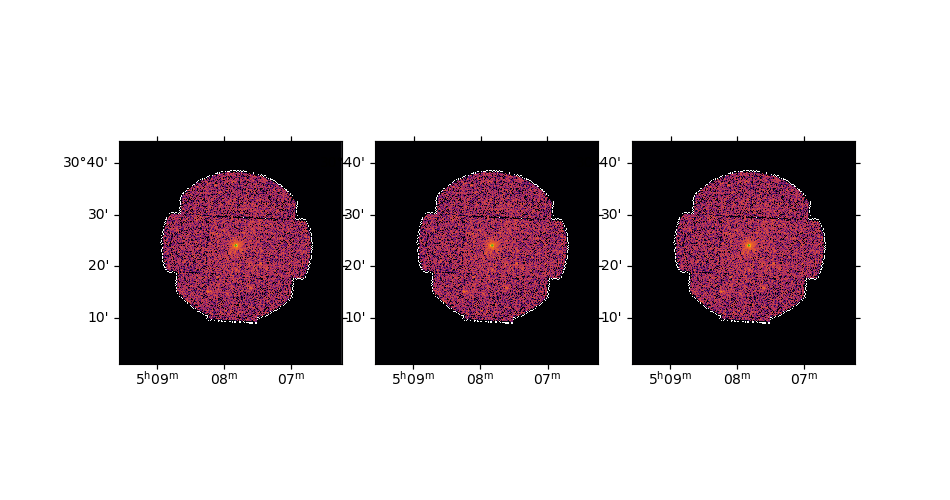

In [57]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9.5,5))
gs = gridspec.GridSpec(1, 3, wspace=0.15, hspace=0.6)

for i in range(3):
    plt.subplot(gs[i], projection=w)
    ax = plt.gca()
    
    ax.imshow(data*4, cmap=cm.inferno, norm=colors.LogNorm(vmin=0.1, vmax=maximum_value), extent=dlim)

    circle1 = plt.Circle((0, 0), 0.2, color='r')
    circle2 = plt.Circle((0.5, 0.5), 0.2, color='blue',zorder=9)
    circle3 = plt.Circle((27175, 27563), 66, color='g', clip_on=False)

#fig, ax = plt.subplots() # note we must use plt.subplots, not plt.subplot
# (or if you have an existing figure)
# fig = plt.gcf()
# ax = fig.gca()

    ax.add_artist(circle1)
    ax.add_artist(circle2)
    ax.add_artist(circle3)
    
plt.show()

In [112]:
A=np.empty((len(dat),), dtype='S25')

In [113]:
col_c = Column(name='correlation', data=A)

In [114]:
dat.add_column(col_c)

In [115]:
dat['correlation']=''

In [117]:
dat

ID,INST,RA,DEC,R,correlation
int16,str25,float64,float64,float64,bytes25
1,M2,10.6189,41.1678,9.056000000000001,
2,M2,10.5895,41.268,9.056000000000001,
3,M2,10.6195,41.2077,9.056000000000001,
4,M2,10.6346,41.2214,9.056000000000001,
5,M2,10.6599,41.2646,10.240000000000002,
6,M2,10.6592,41.2683,9.056000000000001,
7,M2,10.6656,41.268,9.056000000000001,
8,M2,10.6681,41.2635,9.056000000000001,
9,M2,10.6846,41.2765,12.512,


In [106]:
for i in range(len(dat)):
    if dat['ID'][i]==1:
        dat['correlation'][i]+=' triple'
    else:
        dat['correlation'][i]=''

/home/monrillo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: StringTruncateWarning: truncated right side string(s) longer than 25 character(s) during assignment
  This is separate from the ipykernel package so we can avoid doing imports until


In [107]:
dat

ID,INST,RA,DEC,R,correlation
int16,str25,float64,float64,float64,bytes25
1,M2,10.6189,41.1678,9.056000000000001,`��U
2,M2,10.5895,41.268,9.056000000000001,
3,M2,10.6195,41.2077,9.056000000000001,
4,M2,10.6346,41.2214,9.056000000000001,
5,M2,10.6599,41.2646,10.240000000000002,
6,M2,10.6592,41.2683,9.056000000000001,
7,M2,10.6656,41.268,9.056000000000001,
8,M2,10.6681,41.2635,9.056000000000001,
9,M2,10.6846,41.2765,12.512,


In [95]:
with open(path + 'inter_triple_PN_6_M1_1_M2_1_lc.txt', "r") as f:
    for line in f:
        print(line)

0401870301 6 J050750_302416 PN 8 300 0.15599E-37 0.0000

0401870301 1 J050749_302404 M1 8 300 0.0000 0.0000

0401870301 1 J050749_302405 M2 8 300 0.0000 0.0000



In [98]:
with open(path + 'inter_triple_PN_6_M1_1_M2_1_lc.txt', "r") as f:
    for line in f:
        words=line.split()
        if words[3]=='PN':
            src_PN=words[2]
            P_chi_PN=words[6]
            P_KS_PN=words[7]
        elif words[3]=='M1':
            src_M1=words[2]
            P_chi_M1=words[6]
            P_KS_M1=words[7]
        elif words[3]=='M2':
            src_M2=words[2]
            P_chi_M2=words[6]
            P_KS_M2=words[7]

In [113]:
for inst in ('PN','M1','M2'):
    'src_{0}'.format(inst)=1

SyntaxError: can't assign to function call (<ipython-input-113-6b404e91603a>, line 2)

In [116]:
src_PN.replace("_", "+")

'J050750+302416'

In [117]:
P_chi_PN=float(P_chi_PN)

In [118]:
P_chi_PN

1.5599e-38